## Setup

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tqdm.notebook import trange
from Utils.utils import *
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from copy import deepcopy
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
gpus = tf.config.list_physical_devices('GPU')

if (len(gpus) > 0):
    tf.config.set_visible_devices(gpus[1], 'GPU')
    tf.config.get_visible_devices('GPU')

## Global Variables

### Path

In [4]:
DATA_PATH = './data'
MODELS_PATH = './models'
LOGS_PATH = './logs'
PLOTS_PATH = './plots'
PREDICTIONS_PATH = './predictions'
ERRORS_PATH = './errors_table'

### Predictors and Target

In [5]:
PREDICTORS = ['pressao_na_choke', 'abertura_valvula_pneumatica', 'frequencia']
TARGET = 'pressao_na_choke'

### Data

In [6]:
predictors_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
DF = pd.read_parquet(os.path.join(DATA_PATH, 'lea_data_resampled.parquet')).resample('10s').ffill().dropna(how='all')[PREDICTORS]
scaled_data = predictors_scaler.fit_transform(DF)
target_scaler.fit(DF[TARGET].values.reshape(-1, 1))
NORMALIZED_DF = pd.DataFrame(scaled_data, index=DF.index, columns=DF.columns)

#### Train and Evaluate Periods

In [7]:

PERIODS = {"treino":None, "validacao":None}

        
PERIODS["treino"] = [
    ['2021-09-17 23:14', '2021-09-17 23:28'],
    ['2021-09-18 05:14', '2021-09-18 05:28'],
    ['2021-09-18 11:15', '2021-09-18 11:29'],
    ['2021-09-18 17:15', '2021-09-18 17:29'],
    ['2021-09-18 23:15', '2021-09-18 23:29'],
    ['2021-09-19 05:14', '2021-09-19 05:28'],
]

PERIODS["validacao"] = [
    ['2021-09-19 11:15', '2021-09-19 11:29'],
    ['2021-09-19 17:14', '2021-09-19 17:28'],
]

PERIODS["teste"] = [
    ["2021-09-19 23:15", "2021-09-19 23:30"],
    ["2021-09-20 05:15", "2021-09-20 05:30"],
    ["2021-09-19 23:15", "2021-09-20 05:30"],
]

#### Presentation

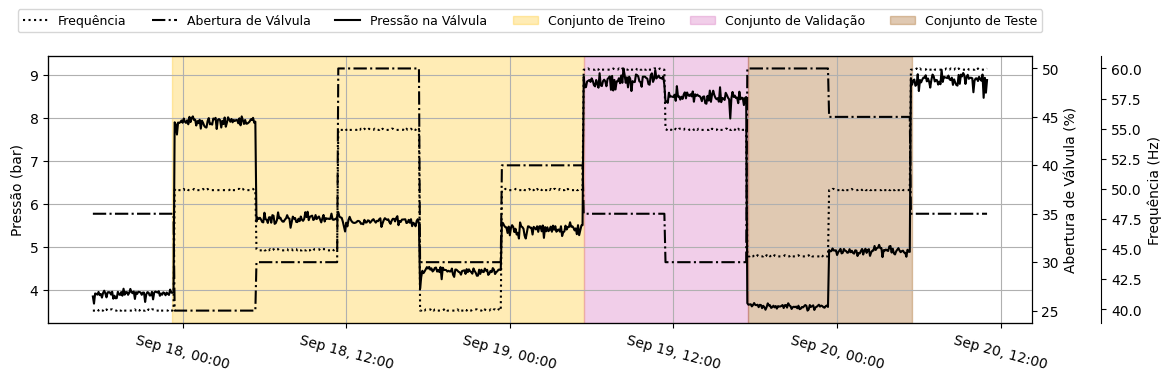

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12, 4))
target = DF[PREDICTORS].resample('5min').ffill()

pressure_color = (0,0,0)
valve_color = (0,0,0)
frequency_color = (0,0,0)
train_period_color = np.divide(np.array([255,194,10]), 255)
val_period_color = np.divide(np.array([211,95,183]), 255)
test_period_color = np.divide(np.array([153,79,0]), 255)
axs = []
ax2 = ax.twinx()
ax3 = ax.twinx()

axs.append(ax3.plot(target['frequencia'], linestyle=':', color = frequency_color, label = 'Frequência')[0])
axs.append(ax2.plot(target['abertura_valvula_pneumatica'], linestyle='-.', color = valve_color, label = 'Abertura de Válvula')[0])
axs.append(ax.plot(target['pressao_na_choke'], linestyle='-', color = pressure_color, label = 'Pressão na Válvula')[0])

ax.set_ylabel('Pressão (bar)', color = (0,0,0))
ax2.set_ylabel('Abertura de Válvula (%)', color = valve_color)
ax3.set_ylabel('Frequência (Hz)', color = frequency_color)

ax2.tick_params(axis='y', colors = valve_color)
ax3.tick_params(axis='y', colors = frequency_color)

ax3.spines['right'].set_position(('outward', 50))  # Adjust position

ax.grid()
ax.tick_params(axis='x', labelsize=10, rotation=-15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))

axs.append(ax.axvspan( PERIODS['treino'][0][0], PERIODS['treino'][-1][1], color=train_period_color, alpha=0.3, label='Conjunto de Treino'))


axs.append(ax.axvspan(PERIODS['treino'][-1][1], PERIODS['validacao'][-1][1], color=val_period_color, alpha=0.3, label='Conjunto de Validação'))

axs.append(ax.axvspan(PERIODS['validacao'][-1][1], PERIODS['teste'][-1][1], color=test_period_color, alpha=0.3, label='Conjunto de Teste'))

labels = [line.get_label() for line in axs]

ax.legend(axs, labels, loc='upper center', bbox_to_anchor=(0.49, 1.2), ncol=6, fontsize=9)
plt.tight_layout()
plt.savefig("figures/dataset.png", dpi=600)  # 300 is a common high-res value
plt.show()

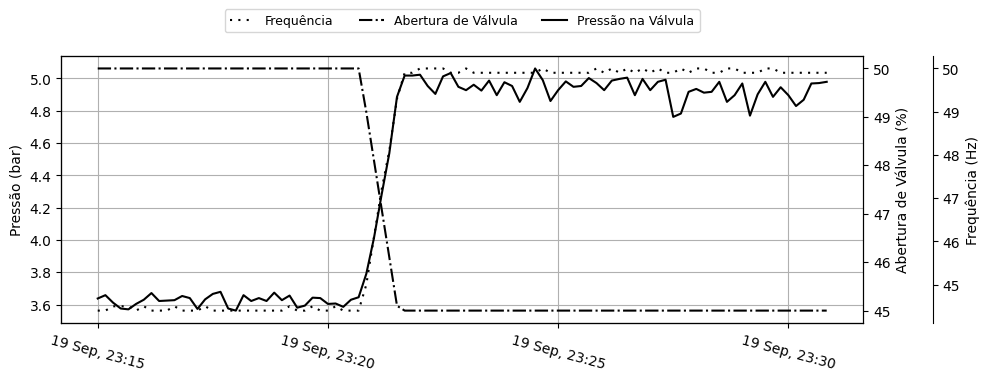

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
target = DF[PERIODS['teste'][0][0]:PERIODS['teste'][0][1]][PREDICTORS]

pressure_color = (0,0,0)
valve_color = pressure_color
frequency_color = pressure_color

axs = []
ax2 = ax.twinx()
ax3 = ax.twinx()

axs.append(ax3.plot(target['frequencia'], linestyle=(0, (1, 3)), color=frequency_color, label='Frequência')[0])
axs.append(ax2.plot(target['abertura_valvula_pneumatica'], linestyle='-.', color=valve_color, label='Abertura de Válvula')[0])
axs.append(ax.plot(target['pressao_na_choke'], linestyle='-', color=pressure_color, label='Pressão na Válvula')[0])

ax.set_ylabel('Pressão (bar)', color=pressure_color)
ax2.set_ylabel('Abertura de Válvula (%)', color=valve_color)
ax3.set_ylabel('Frequência (Hz)', color=frequency_color)

ax2.tick_params(axis='y', colors=valve_color)
ax3.tick_params(axis='y', colors=frequency_color)

ax3.spines['right'].set_position(('outward', 50))  # Ajusta a posição

labels = [line.get_label() for line in axs]

ax.legend(axs, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=6, fontsize=9)
ax.tick_params(axis='x', labelsize=10, rotation=-15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b, %H:%M'))
ax.grid()
plt.tight_layout()
plt.show()

## Functions

In [10]:
class highest_absolute_error(tf.keras.metrics.Metric):
    def __init__(self, name="hae", **kwargs):
        super(highest_absolute_error, self).__init__(name=name, **kwargs)
        self.max_abs_value = self.add_weight(name="max_abs", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_values = tf.abs(y_true - y_pred)
        batch_max = tf.reduce_max(abs_values)
        self.max_abs_value.assign(tf.maximum(self.max_abs_value, batch_max))

    def result(self):
        return self.max_abs_value

    def reset_state(self):
        self.max_abs_value.assign(0.0)


In [11]:
def model_builder(neurons, layer ='LSTM', optimizer_str:str='Nadam', loss:str='mean_squared_error',
                   metrics:list=['mae',  'mse', 'mape', highest_absolute_error()]
                   ) -> tf.keras.Model:
        model = tf.keras.Sequential()

        layer_class = getattr(tf.keras.layers, layer)

        model.add(layer_class(units=neurons, input_shape=[None, 3]))
        model.add(tf.keras.layers.Dense(1))
    
        optimizer_class = getattr(tf.keras.optimizers, optimizer_str)
        optimizer = optimizer_class()

        model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics = metrics
        )
        return model

In [12]:
def plot_train_curves(history:pd.DataFrame, ax, title):

    ax.set_ylim([0, 0.1])
    ax.set_xlabel('Epoch')
    ax.set_title(title, fontsize=11, pad=10)
    ax.plot(history['mae'], label = 'MAE')
    ax.plot(history['val_mae'], label = 'Validation MAE')

    min_mae = history['mae'].min()
    min_val_mae = history['val_mae'].min()

    xindex = history['mae'].idxmin()
    ax.annotate(f'min mae: {min_mae:.4f}', xy = (xindex, history['mae'].min()), 
        xytext =(xindex, history['mae'].min()*2),
        arrowprops = dict(facecolor ='blue', 
                        arrowstyle='->', relpos=(0.3,0.5)),
        fontsize=7)

    xxindex = history['val_mae'].idxmin()
    ax.annotate(f'min val: {min_val_mae:.4f}', xy = (xxindex, history['val_mae'].min()), 
        xytext =(xxindex, history['val_mae'].min()*2),
        arrowprops = dict(facecolor ='orange', 
                        arrowstyle='->', relpos=(0.3,0.5)),
        fontsize=7)
    ax.legend(loc="upper right")
    ax.grid()



In [13]:
def multi_step_prediction_and_plot(
                df:pd.DataFrame, variables:list, target:str, seq_length:int, 
                model:tf.keras.Model, prediction_period:list, prediction_path:str, 
                title:str, ax) -> pd.DataFrame:

    prediction = multi_step_prediction(model, df, variables, target, seq_length, prediction_period)
    erro = mean_absolute_error(prediction['real'], prediction['predicted'])
    prediction.to_json(os.path.join(prediction_path, f'{title}_prediction.json'))

    ax.set_title(f"{title} MAE:{erro:.4f}", pad=10, fontsize=9)
    ax.plot(prediction['real'], label = 'real')
    ax.plot(prediction['predicted'], label = 'predicted')
    ax.legend(loc="upper left")
    ax.grid()
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))

    return prediction

            

In [14]:
def predict(model, df, periodo, seq_length, target, mode='Direct'):
    target_df = df.loc[periodo[0] : periodo[1]]
    
    x = tf.keras.utils.timeseries_dataset_from_array(
        target_df.to_numpy(),
        targets=None,
        sequence_length=seq_length,
        batch_size=1
    )
    n_predictions = len(target_df) - seq_length + 1
    predictions = np.zeros(n_predictions)

    if(mode == "Direct"):
        prediction = model.predict(x, verbose=1)
        predictions[:] = prediction[:,0]

    elif(mode == 'Recursive'):
        x = np.array(list(x.as_numpy_iterator()))
        for i in trange(n_predictions):
            if (i > 0):
                x[i][0, :-1, 0] = x[i - 1][0, 1:, 0]
                x[i][0, -1, 0] = predictions[i - 1]

            prediction = model.predict(x[i], verbose=0)
            predictions[i] = prediction[0, 0]

    idx = df.loc[periodo[0]:].index[seq_length:seq_length+n_predictions]
    return pd.DataFrame({"real" : df.loc[idx, target], 'predicted' : predictions}, index=idx)

In [15]:
def desnormalize_prediction(prediction, y_real):
    y_min, y_max = y_real.min(), y_real.max()
    prediction['predicted'] = (prediction['predicted'] * (y_max - y_min)) + y_min
    prediction['real'] = (prediction['real'] * (y_max - y_min)) + y_min
    return prediction

In [16]:
def plot_prediction(prediction, mae, title, ax):
    ax.set_title(f"{title} MAE:{mae:.4f}", fontsize=10)
    ax.plot(prediction['real'], label = 'real')
    ax.plot(prediction['predicted'], label = 'predicted')
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))
    ax.legend(loc="upper left")
    ax.grid()


## Train Global Variables

In [17]:
loss_functions = {
    'mae' : tf.keras.losses.MeanAbsoluteError(name='mae'),
    'mse' : tf.keras.losses.MeanSquaredError(name='mse'),
    'huber' : tf.keras.losses.Huber(name="huber")
}
layer_sizes = [8, 16, 24, 32, 40, 48]
batch_sizes = [8, 16, 32, 64, 96, 128, 160, 192]

In [18]:
SHUFFLE = True
SEED = 42
SEQ_LENGTH=15
EPOCHS = 10000
PATIENCE = 300
TRAIN_TYPE = '15min'
MONITOR = 'val_mae'
METRICS = [
    tf.keras.losses.MeanAbsoluteError(name='mae'),
    tf.keras.losses.MeanSquaredError(name='mse'),
    tf.keras.losses.MeanAbsolutePercentageError(name='mape'),
    highest_absolute_error()
]

In [19]:
base = {loss : {layer_size : {} for layer_size in layer_sizes} for loss in loss_functions}

models = deepcopy(base)
historys = deepcopy(base)
errors = deepcopy(base)


In [20]:
id_columns = [('','','Loss'), ('','','Neurons',), ('','','BatchSize',)]

train_val_keys = ['Train', 'Validation']
metrics = ['MAE', 'MSE', 'HAE', 'MAPE']
periods = ['T1', 'T2', 'T3']
pred_types = ['Direct', 'Recursive']

global_cols = [('', tv, metric) for tv in train_val_keys for metric in metrics]
pred_cols = [(p, pt, m) for p in periods for pt in pred_types for m in metrics]

all_cols = id_columns + global_cols + pred_cols
multi_index = pd.MultiIndex.from_tuples(all_cols)

df = pd.DataFrame(columns=multi_index)

### Build and Fit Models

In [21]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                                                                monitor=MONITOR,
                                                                patience=PATIENCE,
                                                                restore_best_weights=True,
                                                                mode='min')
                
callbacks = [earlystopping_callback]

## MAE as Loss Function

In [22]:
loss = loss_functions['mae']

In [23]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

### Fill Train and Validation Metrics

In [24]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [25]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {filename} em T{i+1}.')
                    prediction = predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode)
                    prediction = pd.DataFrame(np.column_stack((target_scaler.inverse_transform(prediction['real'].values.reshape(-1, 1)),
                                                               target_scaler.inverse_transform(prediction['predicted'].values.reshape(-1, 1)))),
                                                                index=prediction.index, columns=prediction.columns)
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

In [26]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

## MSE as Loss Function

In [27]:
loss = loss_functions['mse']

In [28]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

### Fill Train and Validation Metrics

In [29]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [30]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {layer_size}n_{loss.name}Loss_{batch_size}bSize em T{i+1}.')
                    prediction = predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode)
                    prediction = pd.DataFrame(np.column_stack((target_scaler.inverse_transform(prediction['real'].values.reshape(-1, 1)),
                                                               target_scaler.inverse_transform(prediction['predicted'].values.reshape(-1, 1)))),
                                                                index=prediction.index, columns=prediction.columns)
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

In [31]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

## Huber as Loss Function

In [32]:
loss = loss_functions['huber']

In [33]:

for layer_size in layer_sizes:
    for batch_size in batch_sizes:
    
        filename = f'{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize'
        model_path = f'{os.path.join(MODELS_PATH, filename)}.h5'
        history_path = f'{os.path.join(LOGS_PATH, filename)}.json'

        if(os.path.exists(model_path) and os.path.exists(history_path)):
            models[loss.name][layer_size][batch_size] = tf.keras.models.load_model(model_path, compile=False)
            historys[loss.name][layer_size][batch_size] = pd.read_json(history_path)
        else:
            print(f'Treinando modelo {filename}.')

            model =  models[loss.name][layer_size][batch_size] = model_builder(neurons=layer_size, loss=loss, metrics=METRICS)
            tf.keras.utils.set_random_seed(SEED)

            train_ds, val_ds = build_ds(NORMALIZED_DF, TARGET, SEQ_LENGTH, PERIODS, shuffle=True, batch_size=batch_size)

            history = model.fit(
                    x=train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=callbacks,
                    verbose=0,
                )
            
            history = historys[loss.name][layer_size][batch_size] = pd.DataFrame(history.history)

            history.to_json(history_path)
            model.save(model_path)

Treinando modelo 15min_LSTM_8n_huberLoss_8bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_16bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_32bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_64bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_96bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_128bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_160bSize.
Treinando modelo 15min_LSTM_8n_huberLoss_192bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_8bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_16bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_32bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_64bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_96bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_128bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_160bSize.
Treinando modelo 15min_LSTM_16n_huberLoss_192bSize.
Treinando modelo 15min_LSTM_24n_huberLoss_8bSize.
Treinando modelo 15min_LSTM_24n_huberLoss_16bSize.
Treinando modelo 15min_LSTM_24n_huberLoss_32bSize.
Treinando modelo 15min_LSTM_24n_hube

### Fill Train and Validation Metrics

In [34]:
for i, layer_size in enumerate(layer_sizes):
    for j, batch_size in enumerate(batch_sizes):

        history = historys[loss.name][layer_size][batch_size]

        best_model_metrics = history.iloc[history['val_mae'].idxmin()]

        errors[loss.name][layer_size][batch_size] = {
                    ('', '', 'Loss'): loss.name,
                    ('', '', 'Neurons'): layer_size,
                    ('', '', 'BatchSize'): batch_size,

                    ('', 'Train', 'MAE'): best_model_metrics['mae'],
                    ('', 'Train', 'MSE'): best_model_metrics['mse'],
                    ('', 'Train', 'HAE'): best_model_metrics['hae'],
                    ('', 'Train', 'MAPE'): best_model_metrics['mape'],

                    ('', 'Validation', 'MAE'): best_model_metrics['val_mae'],
                    ('', 'Validation', 'MSE'): best_model_metrics['val_mse'],
                    ('', 'Validation', 'HAE'): best_model_metrics['val_hae'],
                    ('', 'Validation', 'MAPE'): best_model_metrics['val_mape'],
        }

### Predictions and Metrics

In [35]:
for layer_size in layer_sizes:
    for batch_size in batch_sizes:
        
        error = errors[loss.name][layer_size][batch_size]

        for i, periodo_teste in enumerate(PERIODS["teste"]):
            for mode in ['Direct', 'Recursive']:

                prediction_path = os.path.join(PREDICTIONS_PATH, f'T{i+1}_{mode}_{TRAIN_TYPE}_LSTM_{layer_size}n_{loss.name}Loss_{batch_size}bSize.json')

                if(os.path.exists(prediction_path)):
                    prediction = pd.read_json(prediction_path)
                else:
                    print(f'Fazendo predição {mode} do modelo {filename} em T{i+1}.')
                    prediction = predict(models[loss.name][layer_size][batch_size], NORMALIZED_DF, periodo_teste, SEQ_LENGTH, TARGET, mode=mode)
                    prediction = pd.DataFrame(np.column_stack((target_scaler.inverse_transform(prediction['real'].values.reshape(-1, 1)),
                                                               target_scaler.inverse_transform(prediction['predicted'].values.reshape(-1, 1)))),
                                                                index=prediction.index, columns=prediction.columns)
                    
                    prediction.to_json(prediction_path)
                
                differences = np.abs(prediction['predicted'] - prediction['real'])
                max_absolute_difference = np.max(differences)

                error[(f'T{i+1}', mode, 'MAE')] = mean_absolute_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MSE')] = mean_squared_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'MAPE')] = mean_absolute_percentage_error(prediction['real'], prediction['predicted'])
                error[(f'T{i+1}', mode, 'HAE')] = max_absolute_difference

        df.loc[len(df)] = error

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 901us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 797us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 761us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 847us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 883us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 735us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 808us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 762us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 849us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 806us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 756us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 790us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 744us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 816us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 779us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 828us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 785us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 754us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 825us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 809us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 752us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 977us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 791us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 767us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 819us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 761us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 864us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 767us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 816us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 840us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 773us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 949us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 778us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 978us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 790us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 787us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 817us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 772us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 804us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 780us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 874us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 828us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 784us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 891us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 811us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 826us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 783us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 816us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 828us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 819us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 932us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 887us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 837us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 937us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 784us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 844us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 786us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 865us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 834us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 2ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 938us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 826us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 2ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 877us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 826us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 906us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 871us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 900us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 841us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 880us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 882us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 2ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 929us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 890us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 855us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 862us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 880us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 2ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 835us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 901us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 871us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 832us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 938us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 858us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 813us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 865us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 828us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 852us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 837us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 816us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 939us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 902us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 870us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 989us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 874us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 889us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 865us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 829us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 878us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 852us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 933us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 910us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 873us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 889us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 864us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 974us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 958us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 975us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 994us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.
82/82 [==============================] - 0s 1ms/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T1.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.
82/82 [==============================] - 0s 890us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T2.


  0%|          | 0/82 [00:00<?, ?it/s]

Fazendo predição Direct do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.
2242/2242 [==============================] - 2s 925us/step
Fazendo predição Recursive do modelo 15min_LSTM_48n_huberLoss_192bSize em T3.


  0%|          | 0/2242 [00:00<?, ?it/s]

In [36]:
df[df[('', '', 'Loss')] == loss.name].to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss.name}Loss.xlsx'))

In [37]:
df.to_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_mae-mse-huber.xlsx'))

# Models Analysis

### Predicted and Real values distribution

In [38]:
predictions = {}
lims = {'T1': {'max' : -1, "min" : float('inf')},
        'T2': {'max' : -1, "min" : float('inf')},
        'T3': {'max' : -1, "min" : float('inf')}}

for loss in ['mae', 'mse', 'huber']:
    predictions[loss] = {}
    for t in ['T1', 'T2', 'T3']:
        predictions[loss][t] = pd.DataFrame(columns=['real', 'predicted'])
        for filename in os.listdir(PREDICTIONS_PATH):
            if (all(s in filename for s in [loss, t, 'Recursive'])):
                prediction = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))
                predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)

        local_min = min(predictions[loss][t]['real'].min(), predictions[loss][t]['predicted'].min())
        local_max = max(predictions[loss][t]['real'].max(), predictions[loss][t]['predicted'].max())

        if (local_min < lims[t]['min']):
            lims[t]['min'] = local_min
        if(local_max > lims[t]['max']):
            lims[t]['max'] = local_max


C:\Users\luis\AppData\Local\Temp\ipykernel_2432\4056614110.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)
C:\Users\luis\AppData\Local\Temp\ipykernel_2432\4056614110.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions[loss][t] = pd.concat([predictions[loss][t], prediction], ignore_index=True)
C:\Users\luis\AppData\Local\Temp\ipykernel_2432\4056614110.py:13: FutureWarning: The behavior of Dat

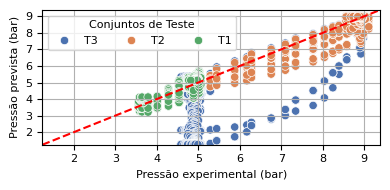

In [39]:
loss = 'mae'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

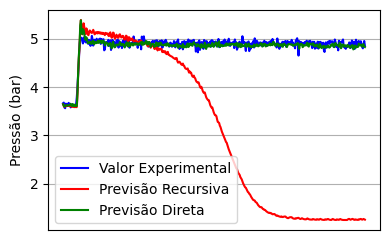

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

for filename in os.listdir(PREDICTIONS_PATH):
    if (all(s in filename for s in ['mae', 'T3', 'Recursive', "24n"])):
        p_d = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))

for filename in os.listdir(PREDICTIONS_PATH):
    if (all(s in filename for s in ['mae', 'T3', 'Direct', "24n"])):
        p_r = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))


ax.plot(p_d['real']['2021-09-19 23:17:30':'2021-09-20 00:31:00'] , label='Valor Experimental', color='blue')
ax.plot(p_d['predicted']['2021-09-19 00:17:30':'2021-09-20 00:31:00'], label='Previsão Recursiva', color='red')
ax.plot(p_r['predicted']['2021-09-19 23:17:30':'2021-09-20 00:31:00'], label='Previsão Direta', color='green')
ax.set_ylabel('Pressão (bar)')
ax.xaxis.set_visible(False)
ax.grid()
ax.legend()
plt.tight_layout()

plt.savefig("figures/prediction_comparison.png", dpi=600)  # 300 is a common high-res value


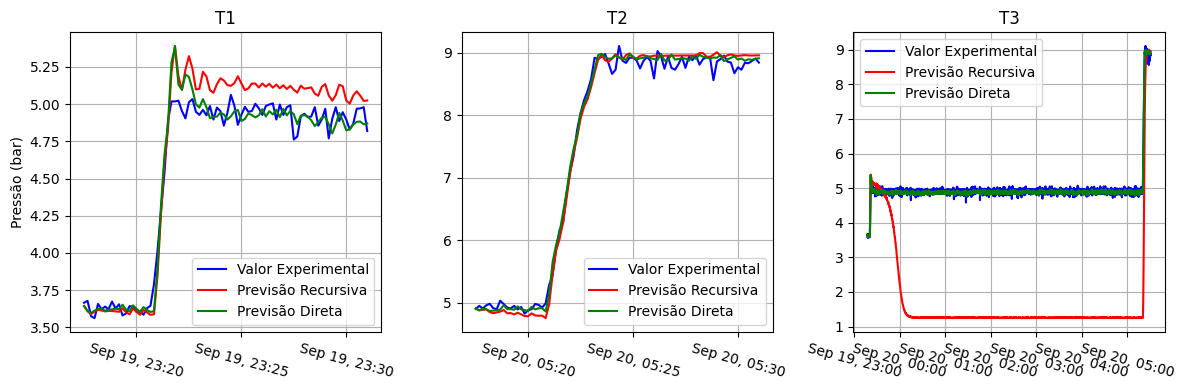

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))


for i in range(3):
    ax = axs[i]

    for filename in os.listdir(PREDICTIONS_PATH):
        if (all(s in filename for s in ['mae', f"T{i+1}", 'Recursive', "24n"])):
            p_d = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))

    for filename in os.listdir(PREDICTIONS_PATH):
        if (all(s in filename for s in ['mae', f"T{i+1}", 'Direct', "24n"])):
            p_r = pd.read_json(os.path.join(PREDICTIONS_PATH, filename))


    ax.plot(p_d['real'] , label='Valor Experimental', color='blue')
    ax.plot(p_d['predicted'], label='Previsão Recursiva', color='red')
    ax.plot(p_r['predicted'], label='Previsão Direta', color='green')
    if(i == 0):
        ax.set_ylabel('Pressão (bar)')
    ax.set_title(f'T{i+1}')
    ax.tick_params(axis='x', labelsize=10, rotation=-15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d, %H:%M'))
    ax.grid()
    ax.legend()
plt.tight_layout()

plt.savefig("figures/prediction_periods_comparison.png", dpi=600)  # 300 is a common high-res value


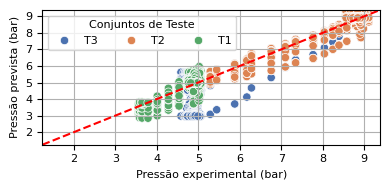

In [42]:
loss = 'mse'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

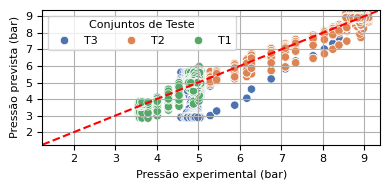

In [43]:
loss = 'huber'

fs = 8
df_list = []
for t in ['T3', 'T2', 'T1']:
    temp = predictions[loss][t].copy()
    temp['Transient'] = t
    df_list.append(temp)
combined_df = pd.concat(df_list, ignore_index=True)

# Define overall limits for the plot
overall_min = min(lims[t]['min'] for t in ['T1', 'T2', 'T3'])
overall_max = max(lims[t]['max'] for t in ['T1', 'T2', 'T3'])

# Create the single scatter plot
plt.figure(figsize=(4, 2))
plot = sns.scatterplot(data=combined_df, x='real', y='predicted', hue='Transient', palette='deep')

# Plot the reference y = x line
plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--')

plt.xlabel('Pressão experimental (bar)', fontsize=fs)
plt.ylabel('Pressão prevista (bar)', fontsize=fs)
plt.xlim(overall_min, overall_max)
plt.ylim(overall_min, overall_max)
plt.grid(True)
plt.legend(title='Conjuntos de Teste', loc='upper left', fontsize=fs, title_fontsize=fs, ncol=3)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout()
plt.savefig(f"figures/predictions_scatter_mae_all_in_one_{loss}.png", dpi=600)
plt.show()

### Tables division

#### MAE

In [44]:
loss = 'mae'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [45]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [46]:
index = ['Train', 'Validation']


In [47]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [48]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE           \
                mean       std      mean       std      mean      std   
Train       0.014929  0.003390  0.000543  0.000333  0.115581  0.04609   
Validation  0.017527  0.003001  0.000929  0.000511  0.177546  0.05299   

                 MAPE            
                 mean       std  
Train        4.842857  1.017207  
Validation  11.827390  4.408086

In [49]:
index = ['T1', 'T2', 'T3']

In [50]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.076204  0.013833  0.011689  0.004078  0.373614  0.054895  0.016639   
T2  0.093934  0.014182  0.016819  0.006611  0.384467  0.051281  0.012714   
T3  0.064323  0.009497  0.006881  0.001810  0.408629  0.044058  0.012956   

              
         std  
T1  0.003406  
T2  0.002066  
T3  0.001956

In [51]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.157452  0.065512  0.041542  0.026908  0.526212  0.136872  0.034038   
T2  0.165810  0.082598  0.070835  0.093007  0.634644  0.350514  0.022584   
T3  0.504040  0.905564  1.174503  3.324548  1.103347  1.095056  0.102264   

              
         std  
T1  0.014689  
T2  0.010821  
T3  0.184082

#### MSE

In [52]:
loss = 'mse'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [53]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [54]:
index = ['Train', 'Validation']


In [55]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [56]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE            \
                mean       std      mean       std      mean       std   
Train       0.016503  0.004681  0.000610  0.000530  0.113398  0.057795   
Validation  0.019313  0.003791  0.001038  0.000659  0.178858  0.053259   

                 MAPE            
                 mean       std  
Train        5.630330  1.924967  
Validation  13.738173  4.456461

In [57]:
index = ['T1', 'T2', 'T3']

In [58]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.083088  0.023292  0.014229  0.007649  0.427452  0.097932  0.018157   
T2  0.095960  0.020215  0.017928  0.009043  0.404405  0.058183  0.012969   
T3  0.070768  0.024426  0.008553  0.005852  0.448942  0.085314  0.014284   

              
         std  
T1  0.005272  
T2  0.002925  
T3  0.005004

In [59]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.175371  0.091104  0.061109  0.061517  0.697277  0.206234  0.038458   
T2  0.169701  0.091093  0.059747  0.074278  0.557775  0.260247  0.022868   
T3  0.200111  0.258153  0.115091  0.480637  0.759027  0.309925  0.040518   

              
         std  
T1  0.020413  
T2  0.011680  
T3  0.052545

#### HUBER

In [60]:
loss = 'huber'
errors = pd.read_excel(os.path.join(ERRORS_PATH, f'errorsTable_{TRAIN_TYPE}_LSTM_{loss}Loss.xlsx'),
                       header=[0,1,2])
errors.columns = pd.MultiIndex.from_tuples([
    tuple("" if str(level).startswith("Unnamed") else level for level in col)
    for col in errors.columns
])

In [61]:
columns = pd.MultiIndex.from_tuples([('MAE', 'mean'), ('MAE', 'std'),
                                    ('MSE', 'mean'), ('MSE', 'std'),
                                    ('HAE', 'mean'), ('HAE', 'std'),
                                    ('MAPE', 'mean'), ('MAPE', 'std'),
                                   ])

In [62]:
index = ['Train', 'Validation']


In [63]:
agg_df = errors.groupby([('', '', "Loss")]).agg(["mean", "std"]).reset_index()

In [64]:

train_metrics = pd.DataFrame(data=[agg_df[('', 'Train')].values.flatten(),
                                    agg_df[('', 'Validation')].values.flatten()],
                                    columns=columns, index=index)
train_metrics

MAE                 MSE                 HAE            \
                mean       std      mean       std      mean       std   
Train       0.016549  0.004633  0.000610  0.000524  0.113263  0.057475   
Validation  0.019311  0.003834  0.001036  0.000657  0.178814  0.052937   

                 MAPE            
                 mean       std  
Train        5.636558  1.904826  
Validation  13.854612  4.585965

In [65]:
index = ['T1', 'T2', 'T3']

In [66]:

direct_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Direct')].values.flatten(),
                                                agg_df[('T2', 'Direct')].values.flatten(),
                                                agg_df[('T3', 'Direct')].values.flatten()],
                                                columns=columns, index=index)
direct_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.082605  0.023752  0.014042  0.007799  0.423833  0.100781  0.018076   
T2  0.095462  0.020237  0.017786  0.009011  0.402624  0.057606  0.012892   
T3  0.069886  0.024499  0.008382  0.005871  0.448965  0.084316  0.014103   

              
         std  
T1  0.005376  
T2  0.002932  
T3  0.005016

In [67]:

recursive_prediction_metrics = pd.DataFrame(data=[agg_df[('T1', 'Recursive')].values.flatten(),
                                                agg_df[('T2', 'Recursive')].values.flatten(),
                                                agg_df[('T3', 'Recursive')].values.flatten()],
                                                columns=columns, index=index)
recursive_prediction_metrics

MAE                 MSE                 HAE                MAPE  \
        mean       std      mean       std      mean       std      mean   
T1  0.169401  0.089962  0.059562  0.061950  0.701079  0.214384  0.037333   
T2  0.164665  0.088592  0.056510  0.073188  0.546517  0.254350  0.022192   
T3  0.190555  0.268120  0.116641  0.526151  0.755588  0.322775  0.038587   

              
         std  
T1  0.020224  
T2  0.011469  
T3  0.054572